<a href="https://colab.research.google.com/github/Rogerio-mack/work/blob/main/Yolov5_Resnet50_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **`Yolov5`, object detection**

Neste exemplo emprego o modelo pré-treinado `Yolov5`  para detectar objetos de interesse, dentre os tipos detectáveis pelo modelo, em 9 imagens de imóveis. Ao final é produzido um hot-encode da presença desses objetos para cada imagem.

```
id	            person ...chair	couch	 bed	...laptop	...refrigerator
/content/1.png	0.0	      1.0	  1.0	   0.0	   0.0	     0.0
/content/2.png	0.0	      1.0	  1.0	   0.0	   0.0	     0.0
...
/content/9.png	0.0	      1.0	  1.0	   0.0	   0.0	     0.0
```

Adicionalmente, incluo a detecção de objetos por outro modelo pré-treinado, o `Resnet50`. Ambos modelos são pré-treinados sobre o mesmo conjunto de dados, o COCO Dataset (https://cocodataset.org/), e os resultados são portanto bastante similares.  

In [5]:
!pip install git+https://github.com/ultralytics/yolov5

# RESTART AFTER

  Cloning https://github.com/ultralytics/yolov5 to /tmp/pip-req-build-9ts036ap
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/yolov5 /tmp/pip-req-build-9ts036ap
  Resolved https://github.com/ultralytics/yolov5 to commit 100a423b66fee81e0a2915d5da934d7872f12c8c
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import cv2
from PIL import Image
from yolov5 import detect

# Load images

In [25]:
import subprocess

for i in range(1, 10):
  subprocess.run(['wget', 'https://raw.githubusercontent.com/Rogerio-mack/work/main/imoveis_images/' + str(i) + '.png'], capture_output=True, text=True)

# Seleciona objetos de interesse

In [81]:
# Carregar o modelo YOLOv5 pré-treinado
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# Obter a lista de todos os objetos reconhecidos pelo YOLOv5
objects = model.names

# Imprimir a lista de objetos
COCO_INSTANCE_CATEGORY_NAMES = []

print("Lista de objetos reconhecidos pelo YOLOv5:")
for idx, obj in objects.items():
    print(f"ID: {idx}, Nome: {obj}")
    COCO_INSTANCE_CATEGORY_NAMES.append(obj)


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-7-2 Python-3.10.12 torch-2.3.0+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Lista de objetos reconhecidos pelo YOLOv5:
ID: 0, Nome: person
ID: 1, Nome: bicycle
ID: 2, Nome: car
ID: 3, Nome: motorcycle
ID: 4, Nome: airplane
ID: 5, Nome: bus
ID: 6, Nome: train
ID: 7, Nome: truck
ID: 8, Nome: boat
ID: 9, Nome: traffic light
ID: 10, Nome: fire hydrant
ID: 11, Nome: stop sign
ID: 12, Nome: parking meter
ID: 13, Nome: bench
ID: 14, Nome: bird
ID: 15, Nome: cat
ID: 16, Nome: dog
ID: 17, Nome: horse
ID: 18, Nome: sheep
ID: 19, Nome: cow
ID: 20, Nome: elephant
ID: 21, Nome: bear
ID: 22, Nome: zebra
ID: 23, Nome: giraffe
ID: 24, Nome: backpack
ID: 25, Nome: umbrella
ID: 26, Nome: handbag
ID: 27, Nome: tie
ID: 28, Nome: suitcase
ID: 29, Nome: frisbee
ID: 30, Nome: skis
ID: 31, Nome: snowboard
ID: 32, Nome: sports ball
ID: 33, Nome: kite
ID: 34, Nome: baseball bat
ID: 35, Nome: baseball glove
ID: 36, Nome: skateboard
ID: 37, Nome: surfboard
ID: 38, Nome: tennis racket
ID: 39, Nome: bottle
ID: 40, Nome: wine glass
ID: 41, Nome: cup
ID: 42, Nome: fork
ID: 43, Nome: knife
ID

# área externa
```
ID: 0, Nome: person
ID: 1, Nome: bicycle
ID: 2, Nome: car
ID: 3, Nome: motorcycle
```
# quartos e salas    
```      
ID: 56, Nome: chair
ID: 57, Nome: couch
ID: 58, Nome: potted plant
ID: 59, Nome: bed
ID: 60, Nome: dining table
ID: 61, Nome: toilet
ID: 62, Nome: tv
ID: 63, Nome: laptop
```
# cozinha   
```                 
ID: 68, Nome: microwave
ID: 69, Nome: oven
ID: 70, Nome: toaster
ID: 71, Nome: sink
ID: 72, Nome: refrigerator
```

In [36]:
ID_of_interest = list(range(0,4)) + list(range(56,64)) + list(range(68,73))

labels_of_interest = []
for i in ID_of_interest:
  labels_of_interest.append(model.names[i])

print(labels_of_interest)

['person', 'bicycle', 'car', 'motorcycle', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator']


# Detecção dos objetos de interesse

Detecta os objetos de cada imagem (`detected_objects`) e gera uma tabela *hot_encode* apenas dos objetos presentes na imagem de interesse (`labels_of_interest`).

In [44]:
# Função para exibir a imagem com as detecções
def display_image_with_boxes(image, results):
    for box in results.xyxy[0]:  # x1, y1, x2, y2, confidence, class
        x1, y1, x2, y2, conf, cls = box
        label = results.names[int(cls)]
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        cv2.putText(image, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

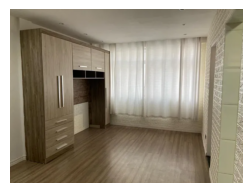

[]


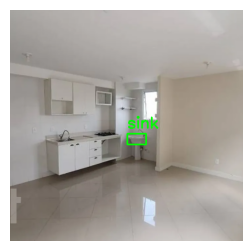

['sink']


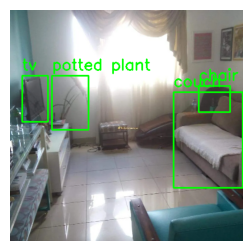

['tv', 'couch', 'chair', 'potted plant']


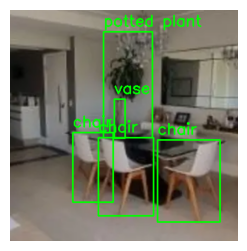

['chair', 'chair', 'chair', 'vase', 'potted plant']


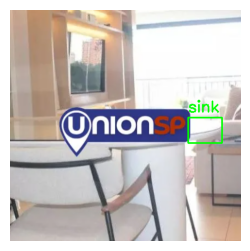

['sink']


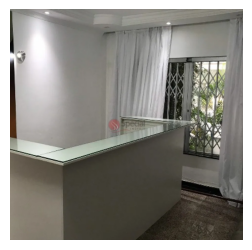

[]


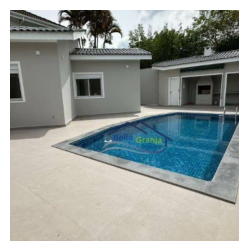

[]


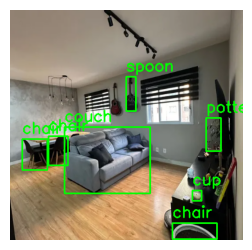

['couch', 'chair', 'chair', 'chair', 'spoon', 'potted plant', 'cup']


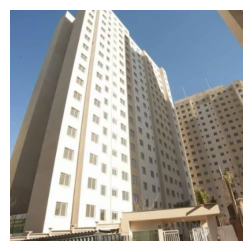

[]


,id,person,bicycle,car,motorcycle,chair,couch,potted plant,bed,dining table,toilet,tv,laptop,microwave,oven,toaster,sink,refrigerator
0,/content/1.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/content/2.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,/content/3.png,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/content/4.png,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/content/5.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,/content/6.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,/content/7.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,/content/8.png,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,/content/9.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
path = '/content/'

nr_images = 9
id = []
hot_encode_objs = np.zeros((nr_images, len(labels_of_interest)))

for i in range(0, nr_images):
  image_path = path + str(i+1) + '.png'
  id.append(image_path)

  # Carregar imagem
  image = cv2.imread(image_path)

  # Realizar a detecção
  results = model(image)

  # Exibir a imagem com as caixas delimitadoras
  plt.figure(figsize=(3,3))
  display_image_with_boxes(image.copy(), results)

  detected_objects = [results.names[int(cls)] for cls in results.xyxy[0][:, 5]]

  print(detected_objects)

  # Verificar a presença de cada rótulo de interesse
  presence = np.array([label in detected_objects for label in labels_of_interest])
  hot_encode_objs[i,:] = presence.astype(int)

pd.set_option("display.max_columns", 100)
df = pd.DataFrame(hot_encode_objs, columns=labels_of_interest)
df['id'] = id
df = pd.concat( [ df[['id']], df[df.columns[0:-1]] ] ,axis=1)
df

In [93]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# **`Resnet50`, Object Detection**

In [94]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import Image
import torchvision.transforms as T

# Carregar o modelo pré-treinado no COCO
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Função para processar a imagem
def process_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    return transform(image).unsqueeze(0)

# Carregar e processar a imagem
for i in range(0, nr_images):
  image_path = path + str(i+1) + '.png'

  image = process_image(image_path)

  # Fazer a previsão
  with torch.no_grad():
      predictions = model(image)

  # Extrair os resultados
  pred_boxes = predictions[0]['boxes'].cpu().numpy()
  pred_labels = predictions[0]['labels'].cpu().numpy()
  pred_scores = predictions[0]['scores'].cpu().numpy()

  # Filtrar resultados com base em uma pontuação mínima
  score_threshold = 0.5
  filtered_boxes = pred_boxes[pred_scores >= score_threshold]
  filtered_labels = pred_labels[pred_scores >= score_threshold]
  filtered_scores = pred_scores[pred_scores >= score_threshold]

  filtered_labels_names = [COCO_INSTANCE_CATEGORY_NAMES[k] for k in filtered_labels]

  # Imprimir os resultados
  # print("Boxes:", filtered_boxes)
  print(image_path + " Objetos: ", filtered_labels_names)
  # print("Scores:", filtered_scores)


/content/1.png Objetos:  []
/content/2.png Objetos:  ['toilet', 'sink', 'oven', 'sink']
/content/3.png Objetos:  ['couch', 'potted plant', 'bottle', 'tv', 'book', 'chair', 'bed']
/content/4.png Objetos:  ['chair', 'chair', 'vase', 'potted plant', 'bottle']
/content/5.png Objetos:  ['sink', 'chair', 'chair']
/content/6.png Objetos:  []
/content/7.png Objetos:  []
/content/8.png Objetos:  ['couch', 'chair', 'chair', 'spoon', 'spoon', 'potted plant', 'cup', 'dining table']
/content/9.png Objetos:  []
